In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Import data and cleaning

In [2]:
df = pd.read_csv('sorting_event_volumes_2023.csv')

df['scanning_date'] = pd.to_datetime(df['scanning_date'], errors='coerce')
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.dayofweek + 1
df['week'] = df['scanning_date'].dt.isocalendar().week
df['week_of_month'] = (df['day'] - 1) // 7 + 1
df['yearday'] = df['scanning_date'].dt.dayofyear  # Voeg de dag van het jaar toe

# Data cleaning
print("Number of rows is: " + str(df.shape[0]))
df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])
print("Number of rows cleaned data is: " + str(df.shape[0]))


Number of rows is: 8949721
Number of rows cleaned data is: 7450939


In [3]:
df_o = df

In [4]:
df = df_o

In [5]:
df

sorting_center_name event_type scanning_date  output_belt  \
16791                VANTAA        LAJ    2023-01-02            1   
16792                VANTAA        LAJ    2023-01-02           10   
16793                VANTAA        LAJ    2023-01-02           10   
16794                VANTAA        LAJ    2023-01-02           10   
16795                VANTAA        LAJ    2023-01-02           10   
...                     ...        ...           ...          ...   
8789785                OULU        LAJ    2023-12-27            0   
8789786                OULU        LAJ    2023-12-27            0   
8789787                OULU        LAJ    2023-12-28            0   
8789788                OULU        LAJ    2023-12-28            0   
8789789                OULU        LAJ    2023-12-29            0   

         no_of_events  day  month  weekday  week  week_of_month  yearday  
16791              13    2      1        1     1              1        2  
16792               4    2      1        1     1              1        2  
16793               2    2      1        1     1              1        2  
16794               7    2      1        1     1              1        2  
16795               3    2      1        1     1              1        2  
...               ...  ...    ...      ...   ...            ...      ...  
8789785           105   27     12        3    52              4      361  
8789786           707   27     12        3    52              4      361  
8789787             3   28     12        4    52              4      362  
8789788           792   28     12        4    52              4      362  
8789789           669   29     12        5    52              5      363  

[7450939 rows x 11 columns]

### Sum the number of events per day, per output belt, per sorting centre. Split on the differrent sorting centres

In [6]:
dfs = {name: group.groupby(['scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum()
       .merge(group[['scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month','yearday']].drop_duplicates(), 
              on='scanning_date', how='left')
       for name, group in df.groupby('sorting_center_name')}

df_VANTAA, df_LIETO, df_TAMPERE, df_SEINÄJOKI, df_KUOPIO, df_OULU = [dfs[name] for name in ['VANTAA', 'LIETO', 'TAMPERE', 'SEINÄJOKI', 'KUOPIO', 'OULU']]

df = dfs['VANTAA']
df


scanning_date  output_belt  no_of_events  day  month  weekday  week  \
0        2023-01-02            0             1    2      1        1     1   
1        2023-01-02            1           533    2      1        1     1   
2        2023-01-02            2           256    2      1        1     1   
3        2023-01-02            3          1422    2      1        1     1   
4        2023-01-02            4          1684    2      1        1     1   
...             ...          ...           ...  ...    ...      ...   ...   
44001    2023-12-30           96           956   30     12        6    52   
44002    2023-12-30           97           692   30     12        6    52   
44003    2023-12-30           98           929   30     12        6    52   
44004    2023-12-30           99            47   30     12        6    52   
44005    2023-12-30          100           540   30     12        6    52   

       week_of_month  yearday  
0                  1        2  
1                  1        2  
2                  1        2  
3                  1        2  
4                  1        2  
...              ...      ...  
44001              5      364  
44002              5      364  
44003              5      364  
44004              5      364  
44005              5      364  

[44006 rows x 9 columns]

### The following piece of codes adds events, with number of events = 0, since they are not in the data set

In [10]:
def fill_missing_events(df):
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())
    all_combinations = pd.MultiIndex.from_product([all_dates, df['output_belt'].unique()], names=['scanning_date', 'output_belt'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    df_filled = pd.merge(all_combinations_df, df, on=['scanning_date', 'output_belt'], how='left')
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1

    return df_filled
    
df_VANTAA = fill_missing_events(df_VANTAA)
df_LIETO = fill_missing_events(df_LIETO)
df_TAMPERE = fill_missing_events(df_TAMPERE)
df_SEINÄJOKI = fill_missing_events(df_SEINÄJOKI)
df_KUOPIO = fill_missing_events(df_KUOPIO)
df_OULU = fill_missing_events(df_OULU)


## Embeddings
#### Making a vector of all possible combinations, category_comb, and giving this a unique number category_encoded

In [8]:
def encode_category_combinations(df):
    df['category_comb'] = (
        df['output_belt'].astype(str) + '_' + 
        df['day'].astype(str) + '_' + 
        df['weekday'].astype(str) + '_' + 
        df['week_of_month'].astype(str)
    )
    # Encodeer de gecombineerde categorieën
    df['category_encoded'] = df['category_comb'].astype('category').cat.codes
    return df


In [9]:
# Toepassen op alle dataframes in de 'dfs' dictionary
dfs = {name: encode_category_combinations(df) for name, df in dfs.items()}


In [10]:
class EventDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.inputs = torch.tensor(self.data['category_encoded'].values, dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values, dtype=torch.float32)
        self.output_belt = torch.tensor(self.data['output_belt'].values, dtype=torch.long)
        self.yearday = torch.tensor(self.data['yearday'].values, dtype=torch.long)  # Voeg yearday toe

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

# Functie voor het splitsen van de dataset en het maken van de DataLoader
def create_dataloaders_for_df(df, test_size=0.25, batch_size=512, method='sequential'):
    train_df, test_df = split_dataset(df, method=method, test_size=test_size)

    # Initialiseer de DataLoaders
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Functie voor het splitsen van de dataset
def split_dataset(df, method='sequential', test_size=0.25):
    if method == 'random':
        return train_test_split(df, test_size=test_size, random_state=42)
    else:  # 'sequential'
        split_idx = int((1 - test_size) * len(df))
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        return train_df, test_df



In [11]:
# Dictionary om alle loaders per sorting center op te slaan
loaders = {}

# Voor elk sorting center in dfs de loaders maken
for name, df in dfs.items():
    train_loader, test_loader = create_dataloaders_for_df(df)
    loaders[name] = {
        'train_loader': train_loader,
        'test_loader': test_loader
    }


In [13]:
loaders

{'KUOPIO': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4950110>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x207f49537a0>},
 'LIETO': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4953110>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4952c90>},
 'OULU': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4953b90>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4952180>},
 'SEINÄJOKI': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4950500>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4950980>},
 'TAMPERE': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4951040>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4951490>},
 'VANTAA': {'train_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4951b20>,
  'test_loader': <torch.utils.data.dataloader.DataLoader at 0x207f4ab74a0>}}

In [12]:
class SimpleNN(nn.Module):
    def __init__(self, num_categories, embedding_dim):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        # print(x.shape)
        # print(x[0])
        x = self.embedding(x)
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.bn3(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


Training model for sorting center: KUOPIO
Epoch [1/200], Train Loss: 200.9890, Test Loss: 176.9522, MSE: 66242.0745, MAE: 176.9522, LR: 0.030000
Epoch [2/200], Train Loss: 148.7623, Test Loss: 146.8657, MSE: 40197.7799, MAE: 146.8657, LR: 0.030000
Epoch [3/200], Train Loss: 127.2932, Test Loss: 122.8522, MSE: 33850.2077, MAE: 122.8522, LR: 0.030000
Epoch [4/200], Train Loss: 95.6136, Test Loss: 104.7005, MSE: 26695.7597, MAE: 104.7005, LR: 0.030000
Epoch [5/200], Train Loss: 77.5730, Test Loss: 94.9905, MSE: 22659.0015, MAE: 94.9905, LR: 0.030000
Epoch [6/200], Train Loss: 66.8595, Test Loss: 90.2796, MSE: 20394.6346, MAE: 90.2796, LR: 0.030000
Epoch [7/200], Train Loss: 58.8194, Test Loss: 88.3886, MSE: 18889.4833, MAE: 88.3886, LR: 0.030000
Epoch [8/200], Train Loss: 54.6134, Test Loss: 83.6314, MSE: 17554.9595, MAE: 83.6314, LR: 0.030000
Epoch [9/200], Train Loss: 51.6008, Test Loss: 81.2953, MSE: 16462.4450, MAE: 81.2953, LR: 0.030000
Epoch [10/200], Train Loss: 49.2143, Test Loss:

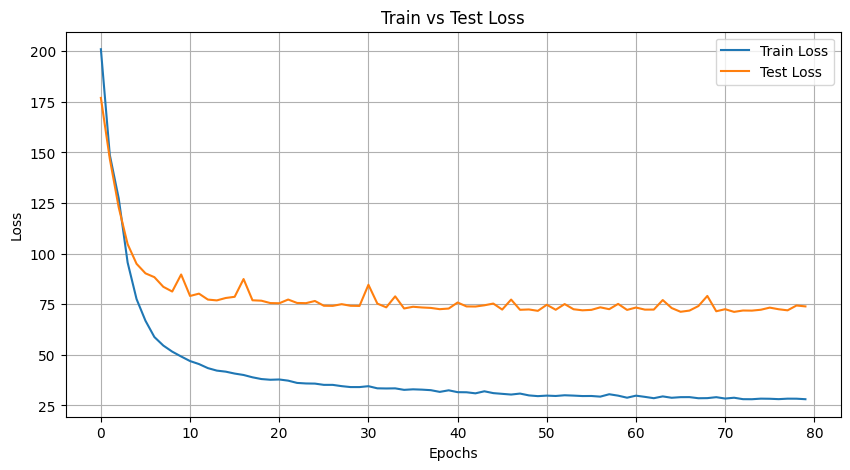

MSE for KUOPIO: 11842.5504, MAE: 73.9507, VSE: 55903088.0000
Training model for sorting center: LIETO
Epoch [1/200], Train Loss: 278.2426, Test Loss: 266.5456, MSE: 155110.9965, MAE: 266.5456, LR: 0.030000
Epoch [2/200], Train Loss: 213.5150, Test Loss: 218.3020, MSE: 100202.8186, MAE: 218.3020, LR: 0.030000
Epoch [3/200], Train Loss: 172.2145, Test Loss: 178.8049, MSE: 77100.5710, MAE: 178.8049, LR: 0.030000
Epoch [4/200], Train Loss: 134.9960, Test Loss: 164.1768, MSE: 65215.5763, MAE: 164.1768, LR: 0.030000
Epoch [5/200], Train Loss: 122.9975, Test Loss: 153.6380, MSE: 58714.3762, MAE: 153.6380, LR: 0.030000
Epoch [6/200], Train Loss: 111.3886, Test Loss: 149.5968, MSE: 57236.2745, MAE: 149.5968, LR: 0.030000
Epoch [7/200], Train Loss: 102.3441, Test Loss: 146.9697, MSE: 56951.5872, MAE: 146.9697, LR: 0.030000
Epoch [8/200], Train Loss: 95.6856, Test Loss: 141.4481, MSE: 52024.2942, MAE: 141.4481, LR: 0.030000
Epoch [9/200], Train Loss: 88.6866, Test Loss: 139.4609, MSE: 51035.2484,

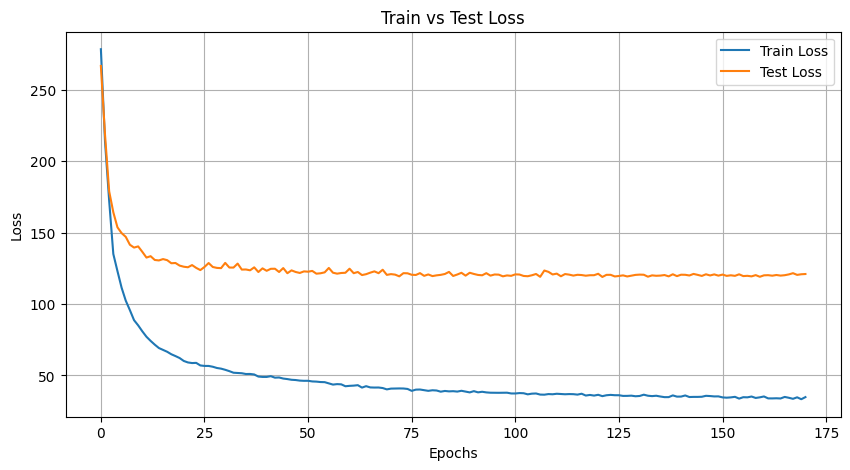

MSE for LIETO: 40432.1061, MAE: 120.9703, VSE: 113228896.0000
Training model for sorting center: OULU
Epoch [1/200], Train Loss: 173.4861, Test Loss: 183.1992, MSE: 78570.1294, MAE: 183.1992, LR: 0.030000
Epoch [2/200], Train Loss: 147.9266, Test Loss: 167.2038, MSE: 60781.9857, MAE: 167.2038, LR: 0.030000
Epoch [3/200], Train Loss: 128.6188, Test Loss: 136.4376, MSE: 48337.8370, MAE: 136.4376, LR: 0.030000
Epoch [4/200], Train Loss: 96.5702, Test Loss: 115.3225, MSE: 37917.6706, MAE: 115.3225, LR: 0.030000
Epoch [5/200], Train Loss: 77.0085, Test Loss: 106.2200, MSE: 32740.4145, MAE: 106.2200, LR: 0.030000
Epoch [6/200], Train Loss: 65.7837, Test Loss: 97.5562, MSE: 28893.4469, MAE: 97.5562, LR: 0.030000
Epoch [7/200], Train Loss: 58.1997, Test Loss: 92.5148, MSE: 26381.6267, MAE: 92.5148, LR: 0.030000
Epoch [8/200], Train Loss: 51.8029, Test Loss: 92.2469, MSE: 26105.6412, MAE: 92.2469, LR: 0.030000
Epoch [9/200], Train Loss: 48.2702, Test Loss: 88.3849, MSE: 24443.4818, MAE: 88.3849

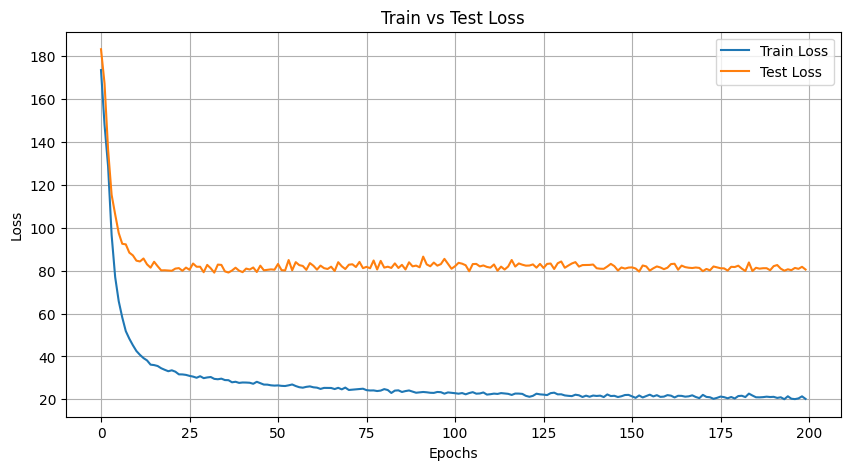

MSE for OULU: 21516.5287, MAE: 80.5127, VSE: 29435060.0000
Training model for sorting center: SEINÄJOKI
Epoch [1/200], Train Loss: 561.8017, Test Loss: 610.7642, MSE: 514480.8375, MAE: 610.7642, LR: 0.030000
Epoch [2/200], Train Loss: 551.0480, Test Loss: 593.9088, MSE: 492945.0812, MAE: 593.9088, LR: 0.030000
Epoch [3/200], Train Loss: 527.9855, Test Loss: 560.3420, MSE: 449935.5563, MAE: 560.3420, LR: 0.030000
Epoch [4/200], Train Loss: 487.3000, Test Loss: 480.2035, MSE: 353517.2188, MAE: 480.2035, LR: 0.030000
Epoch [5/200], Train Loss: 426.6587, Test Loss: 407.3660, MSE: 270051.5062, MAE: 407.3660, LR: 0.030000
Epoch [6/200], Train Loss: 352.0549, Test Loss: 326.4098, MSE: 187512.3813, MAE: 326.4098, LR: 0.030000
Epoch [7/200], Train Loss: 270.1091, Test Loss: 254.0639, MSE: 120948.8570, MAE: 254.0639, LR: 0.030000
Epoch [8/200], Train Loss: 200.6240, Test Loss: 216.8183, MSE: 87749.4187, MAE: 216.8183, LR: 0.030000
Epoch [9/200], Train Loss: 162.9784, Test Loss: 194.5121, MSE: 73

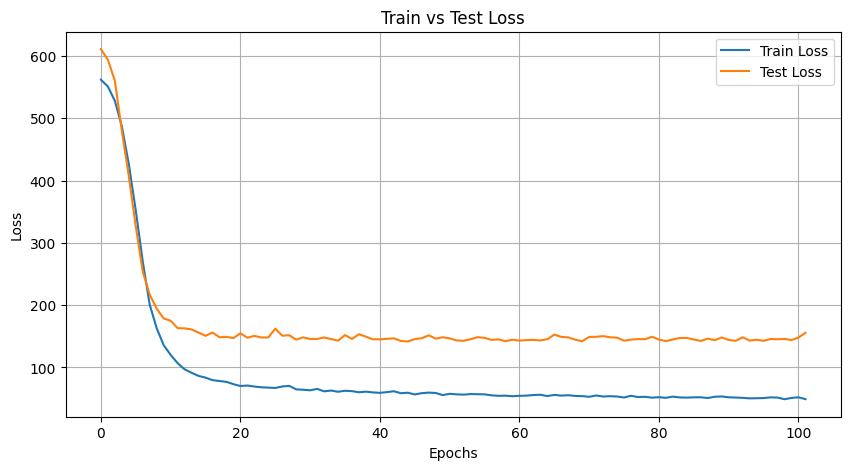

MSE for SEINÄJOKI: 47928.2631, MAE: 155.5117, VSE: 7058773504.0000
Training model for sorting center: TAMPERE
Epoch [1/200], Train Loss: 234.4302, Test Loss: 227.3047, MSE: 116464.0080, MAE: 227.3047, LR: 0.030000
Epoch [2/200], Train Loss: 190.3339, Test Loss: 192.3444, MSE: 91613.6061, MAE: 192.3444, LR: 0.030000
Epoch [3/200], Train Loss: 149.8480, Test Loss: 156.2555, MSE: 72019.2873, MAE: 156.2555, LR: 0.030000
Epoch [4/200], Train Loss: 116.0452, Test Loss: 144.1272, MSE: 65128.8941, MAE: 144.1272, LR: 0.030000
Epoch [5/200], Train Loss: 101.2756, Test Loss: 133.0982, MSE: 58987.9140, MAE: 133.0982, LR: 0.030000
Epoch [6/200], Train Loss: 90.3459, Test Loss: 130.4410, MSE: 57627.5121, MAE: 130.4410, LR: 0.030000
Epoch [7/200], Train Loss: 84.8419, Test Loss: 124.7531, MSE: 53378.9262, MAE: 124.7531, LR: 0.030000
Epoch [8/200], Train Loss: 79.3481, Test Loss: 123.8756, MSE: 53593.1431, MAE: 123.8756, LR: 0.030000
Epoch [9/200], Train Loss: 75.1598, Test Loss: 121.0213, MSE: 51884.

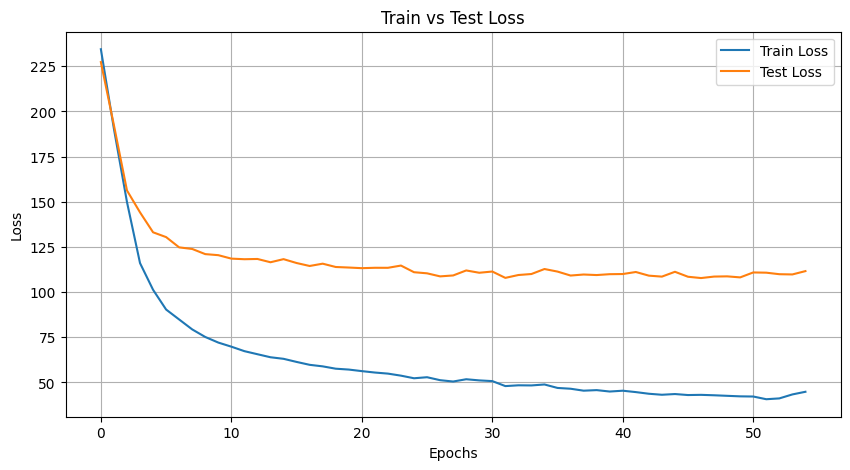

MSE for TAMPERE: 34235.5907, MAE: 111.6168, VSE: 245651440.0000
Training model for sorting center: VANTAA
Epoch [1/200], Train Loss: 883.2632, Test Loss: 891.5385, MSE: 2717570.4347, MAE: 891.5385, LR: 0.030000
Epoch [2/200], Train Loss: 695.5878, Test Loss: 728.4048, MSE: 2077016.8267, MAE: 728.4048, LR: 0.030000
Epoch [3/200], Train Loss: 571.2445, Test Loss: 624.4788, MSE: 1872998.6761, MAE: 624.4788, LR: 0.030000
Epoch [4/200], Train Loss: 441.7921, Test Loss: 541.6682, MSE: 1639131.8622, MAE: 541.6682, LR: 0.030000
Epoch [5/200], Train Loss: 359.2821, Test Loss: 493.1720, MSE: 1480037.7401, MAE: 493.1720, LR: 0.030000
Epoch [6/200], Train Loss: 309.8285, Test Loss: 476.1513, MSE: 1417699.2670, MAE: 476.1513, LR: 0.030000
Epoch [7/200], Train Loss: 276.7683, Test Loss: 451.7384, MSE: 1324254.2301, MAE: 451.7384, LR: 0.030000
Epoch [8/200], Train Loss: 255.7284, Test Loss: 447.0818, MSE: 1301112.8849, MAE: 447.0818, LR: 0.030000
Epoch [9/200], Train Loss: 239.6407, Test Loss: 442.78

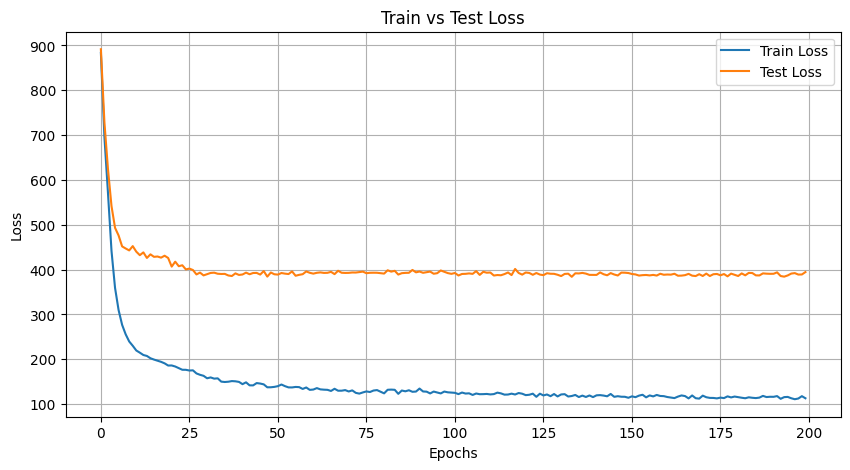

MSE for VANTAA: 457953.3711, MAE: 394.4770, VSE: 94148075520.0000


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

trained_models = {}

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=5, min_delta=0.01):
    train_losses, test_losses = [], []
    mse_losses, mae_losses = [], []
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _, _ in train_loader:
            inputs = inputs.to(device)
            targets = targets.float().to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs).squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_loss = 0.0
        total_mse = 0.0
        total_mae = 0.0
        with torch.no_grad():
            for inputs, targets, _, _ in test_loader:
                inputs = inputs.to(device)
                targets = targets.float().to(device)
                outputs = model(inputs).squeeze()

                mse_loss = nn.MSELoss()(outputs, targets)
                mae_loss = nn.L1Loss()(outputs, targets)
                
                total_loss += criterion(outputs, targets).item()
                total_mse += mse_loss.item()
                total_mae += mae_loss.item()

        avg_test_loss = total_loss / len(test_loader)
        avg_mse_loss = total_mse / len(test_loader)
        avg_mae_loss = total_mae / len(test_loader)

        test_losses.append(avg_test_loss)
        mse_losses.append(avg_mse_loss)
        mae_losses.append(avg_mae_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, MSE: {avg_mse_loss:.4f}, MAE: {avg_mae_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if epoch >= patience:
            if avg_test_loss > test_losses[-patience]:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0
        
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break

    vse = torch.var(torch.tensor(mse_losses)).item()
    return train_losses, test_losses, mse_losses, mae_losses, vse

def train_model_for_sorting_centers(dfs):
    for name, df in dfs.items():
        print(f"Training model for sorting center: {name}")
        num_categories = len(df['category_encoded'].unique())
        embedding_dim = 4

        model = SimpleNN(num_categories=num_categories, embedding_dim=embedding_dim).to(device)
        criterion = nn.L1Loss()
        optimizer = optim.Adam(model.parameters(), lr=0.03)

        train_loader, test_loader = create_dataloaders_for_df(df)

        train_losses, test_losses, mse_losses, mae_losses, vse = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=200)

        plot_losses(train_losses, test_losses)

        print(f"MSE for {name}: {mse_losses[-1]:.4f}, MAE: {mae_losses[-1]:.4f}, VSE: {vse:.4f}")

        trained_models[name] = model

train_model_for_sorting_centers(dfs)


Plotting for Sorting Center: KUOPIO


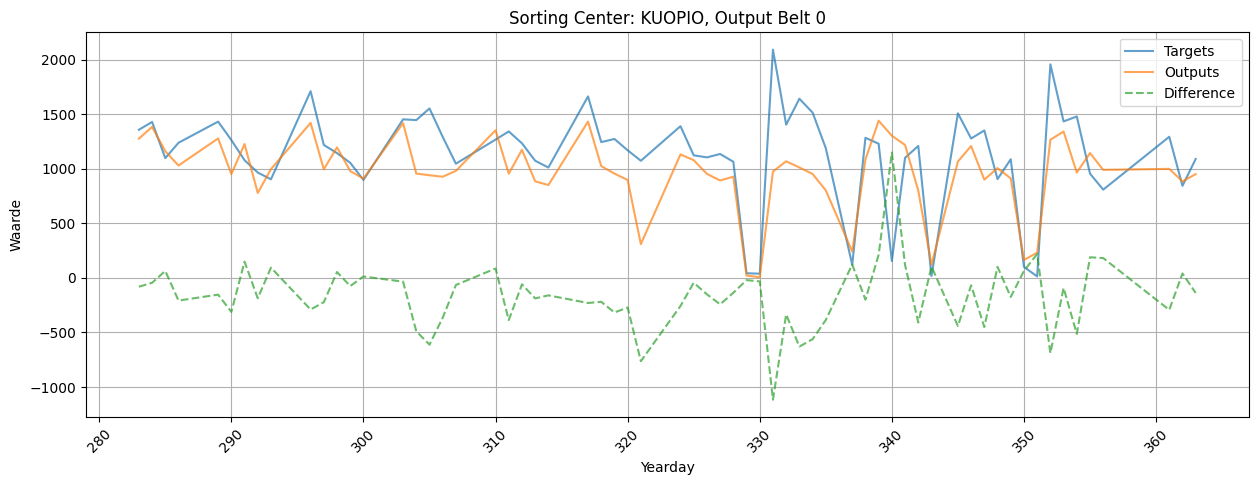

Plotting for Sorting Center: LIETO
No belts defined for sorting center: LIETO
Plotting for Sorting Center: OULU


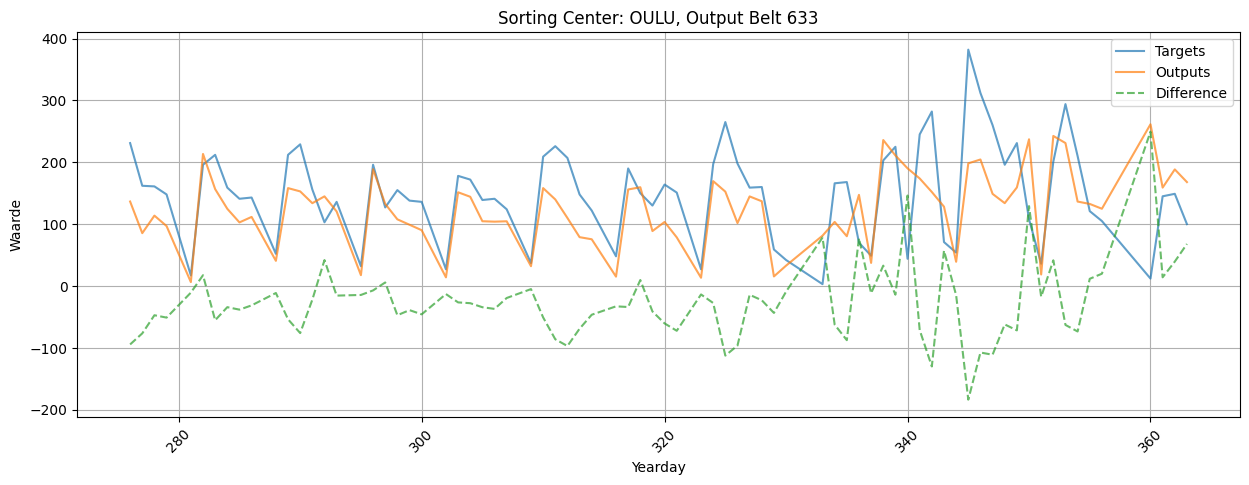

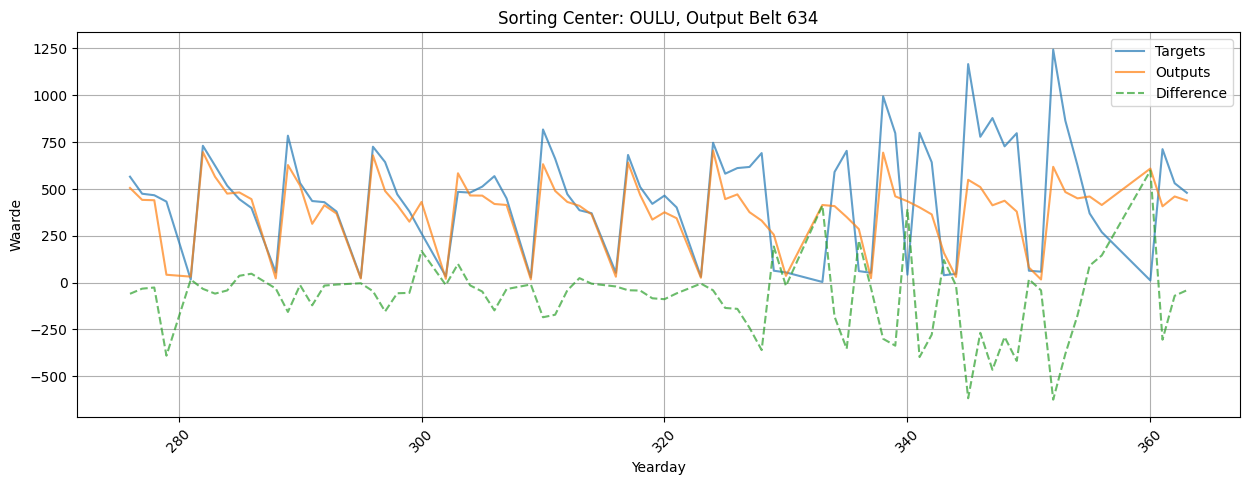

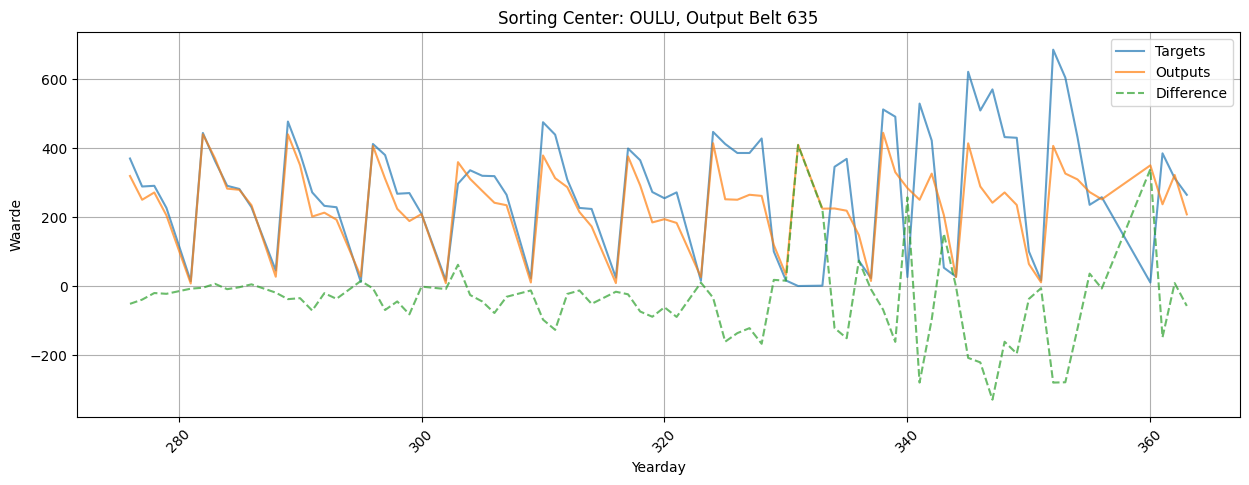

Plotting for Sorting Center: SEINÄJOKI
No belts defined for sorting center: SEINÄJOKI
Plotting for Sorting Center: TAMPERE
No belts defined for sorting center: TAMPERE
Plotting for Sorting Center: VANTAA
No belts defined for sorting center: VANTAA


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_output_belts_for_center(model, test_loader, sorting_center_name, belts):
    all_outputs, all_targets, all_output_belts, all_yeardays = [], [], [], []

    for inputs, targets, output_belts, yearday in test_loader:
        inputs, targets = inputs.to(device), targets.float().to(device)
        all_outputs.append(model(inputs).squeeze().cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        all_output_belts.append(output_belts.cpu().numpy())
        all_yeardays.append(yearday.cpu().numpy())

    all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, 
                                                                   (all_outputs, all_targets, all_output_belts, all_yeardays))

    for belt in belts:
        mask = all_output_belts == belt
        if mask.any():
            sort_idx = np.argsort(all_yeardays[mask])
            plt.figure(figsize=(15, 5))
            plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
            plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
            plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], 
                     label='Difference', linestyle='--', alpha=0.7)
            plt.xlabel('Yearday')
            plt.ylabel('Waarde')
            plt.title(f'Sorting Center: {sorting_center_name}, Output Belt {belt}')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()


def plot_for_all_centers(models, loaders, belts_per_center):
    for name, model in models.items():
        print(f"Plotting for Sorting Center: {name}")
        test_loader = loaders[name]['test_loader']

        # Gebruik een lege lijst als er geen belts zijn opgegeven voor dit sorting center
        belts = belts_per_center.get(name, [])
        if belts:
            plot_output_belts_for_center(model, test_loader, name, belts)
        else:
            print(f"No belts defined for sorting center: {name}")




## Model for all rural (so no VANTTAA)

Plotting for Sorting Center: KUOPIO


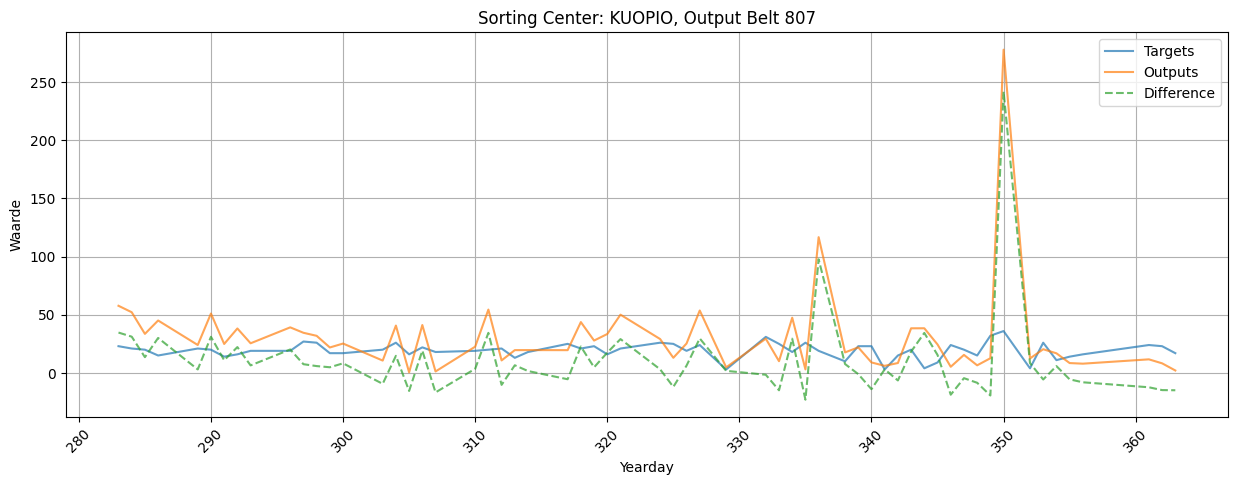

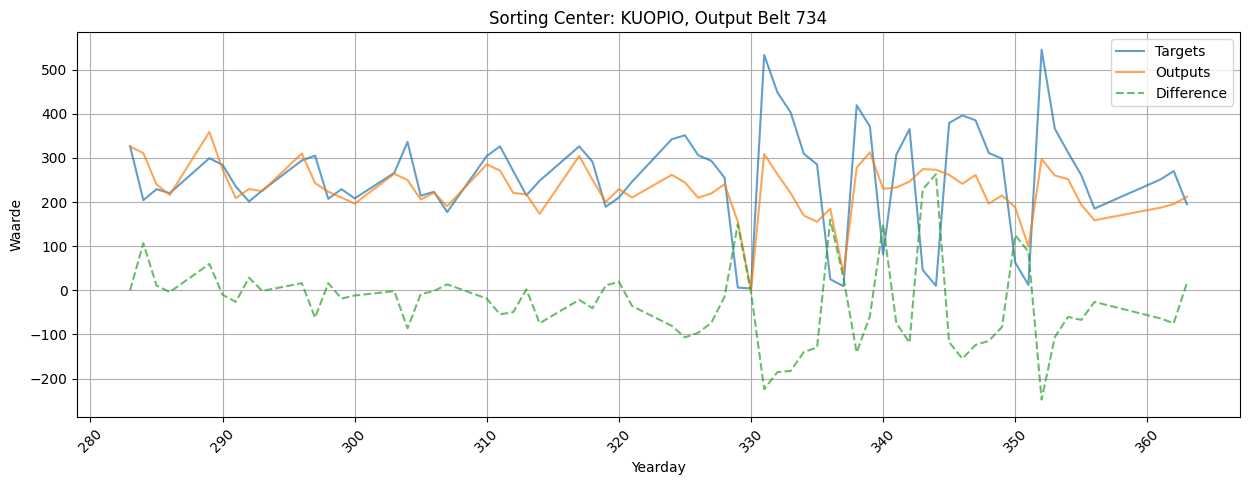

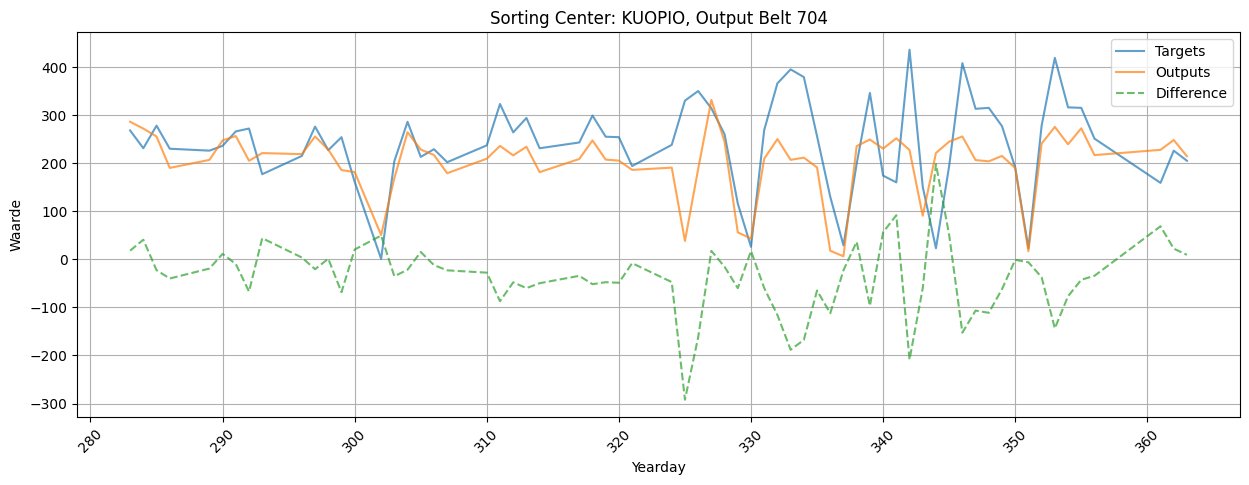

Plotting for Sorting Center: LIETO


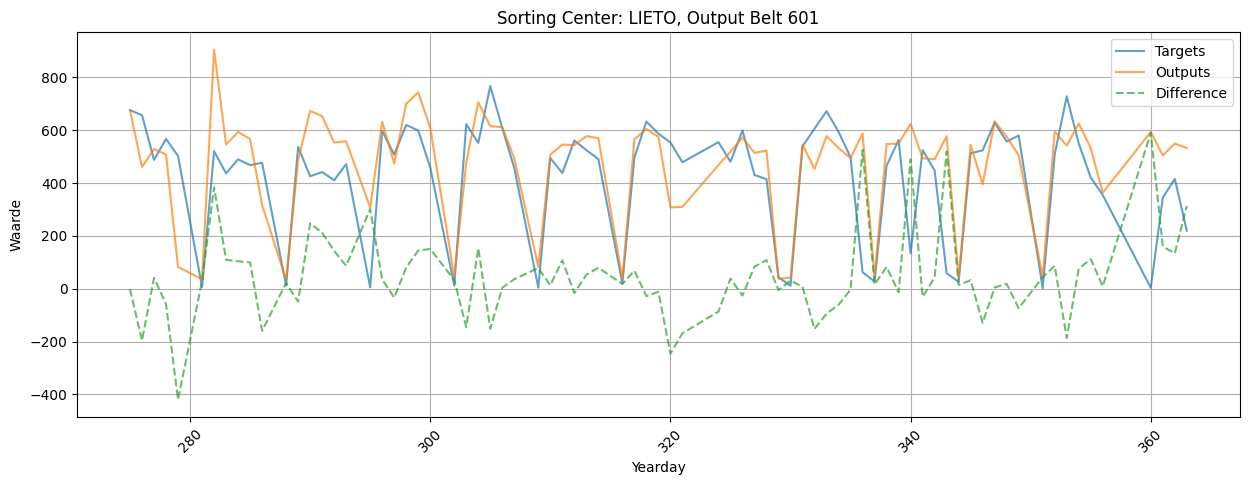

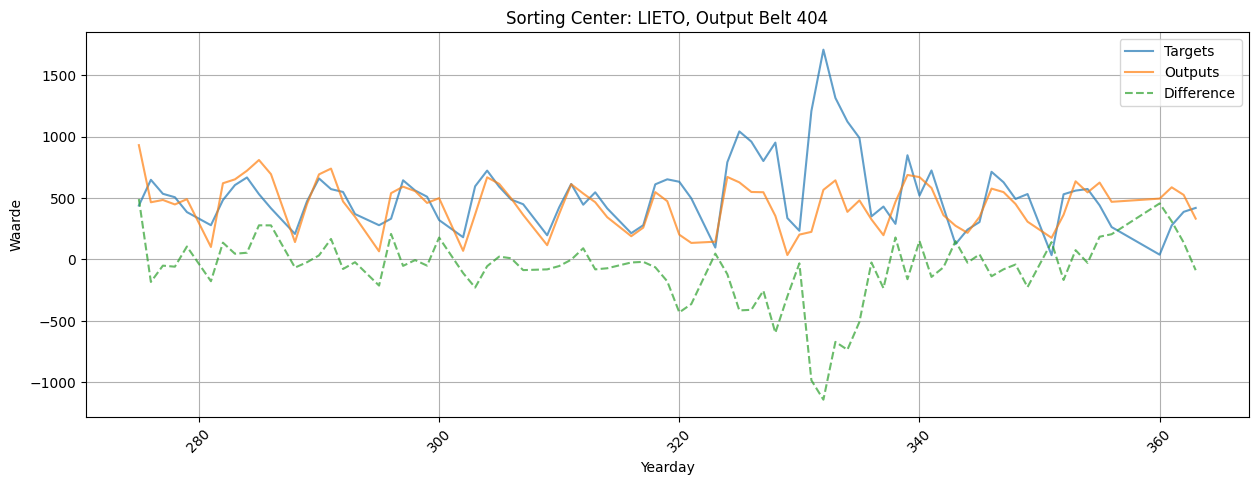

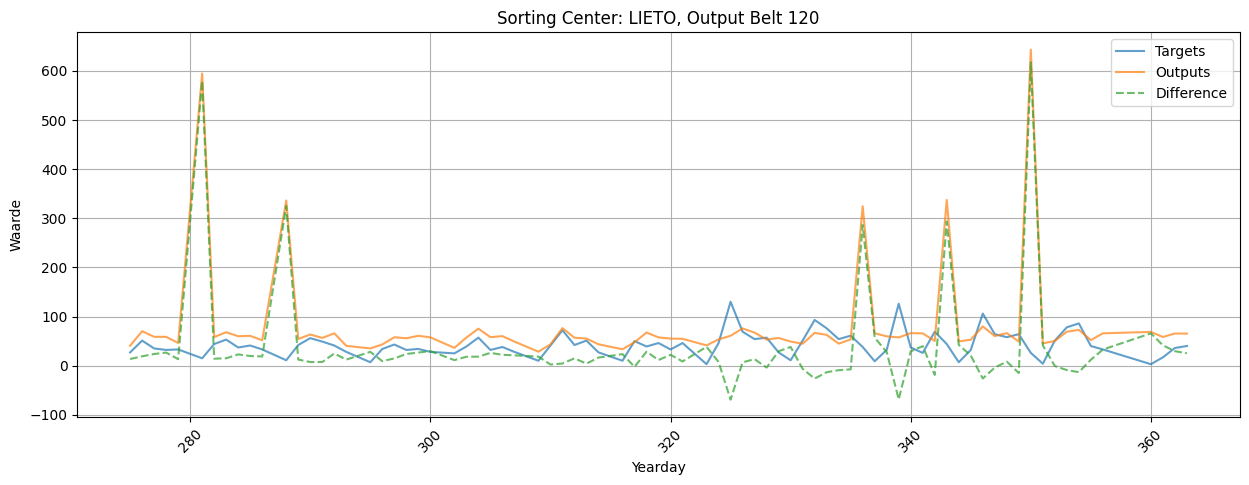

Plotting for Sorting Center: OULU


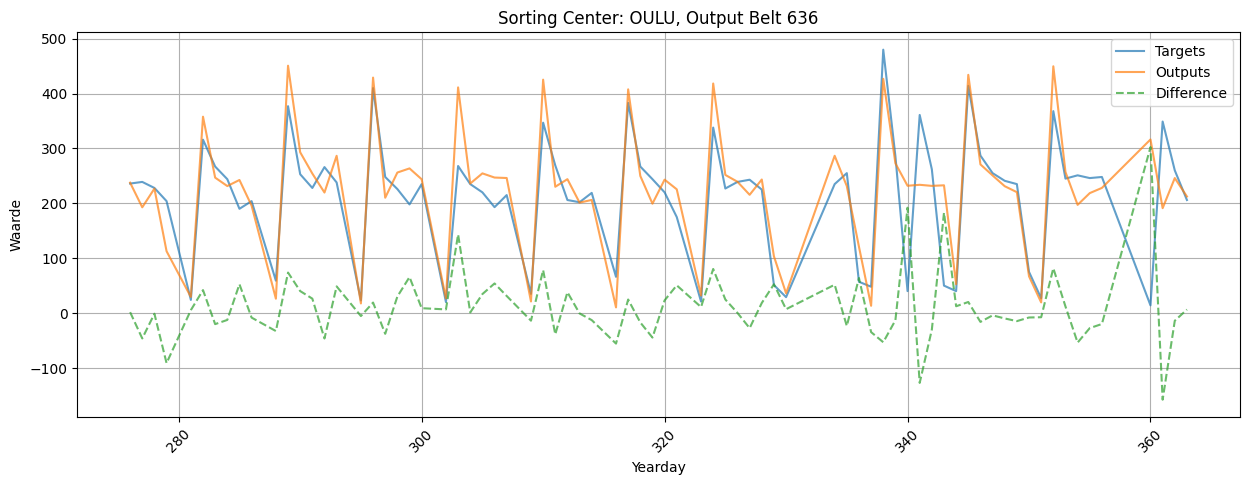

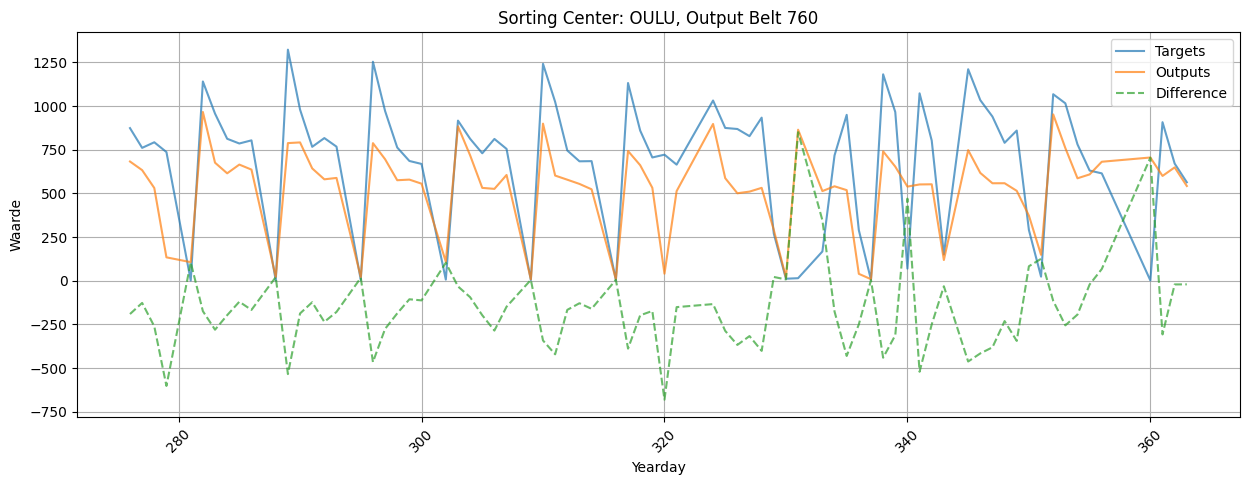

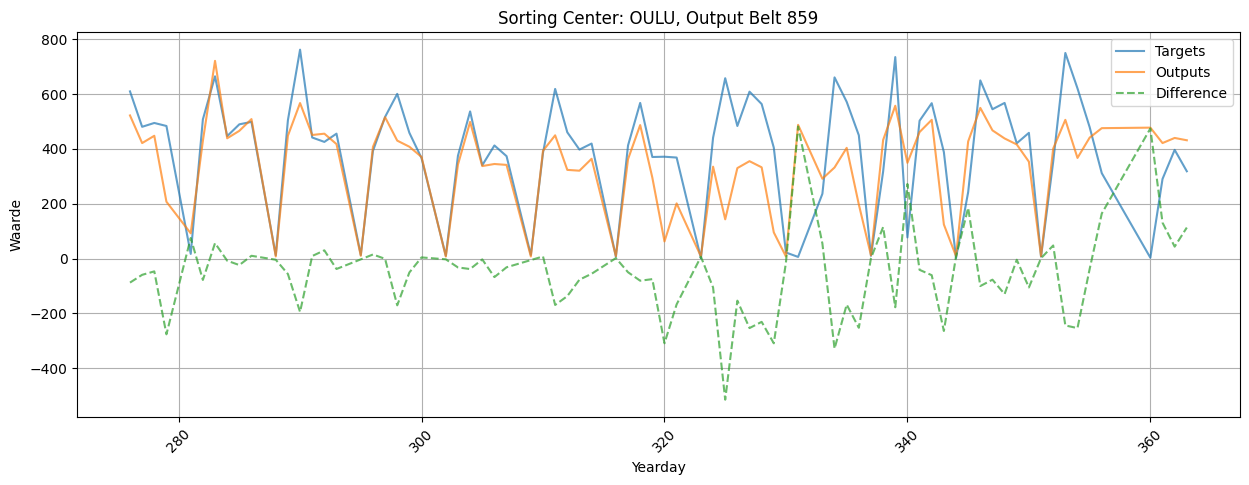

Plotting for Sorting Center: SEINÄJOKI


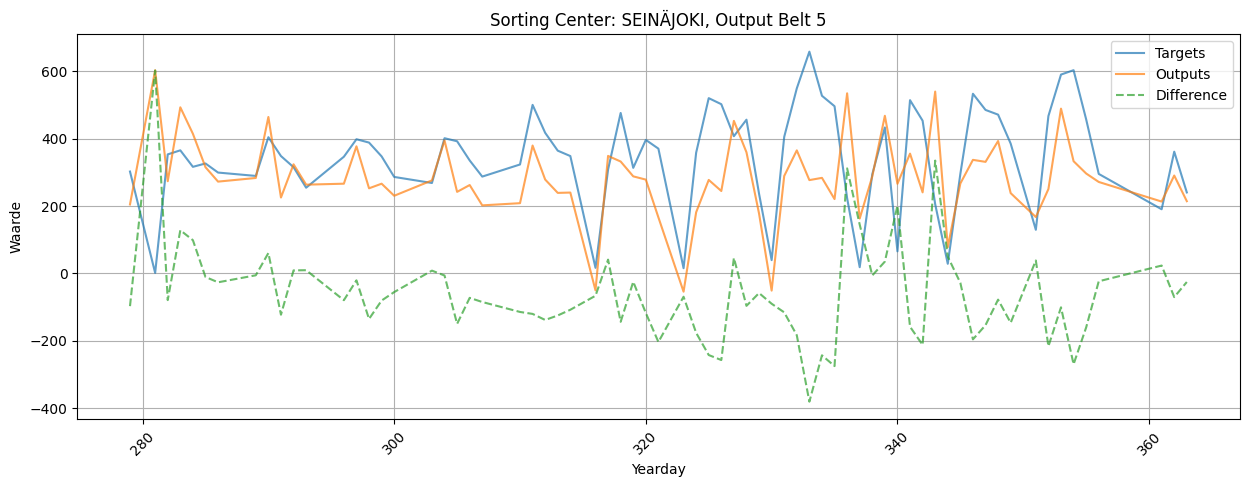

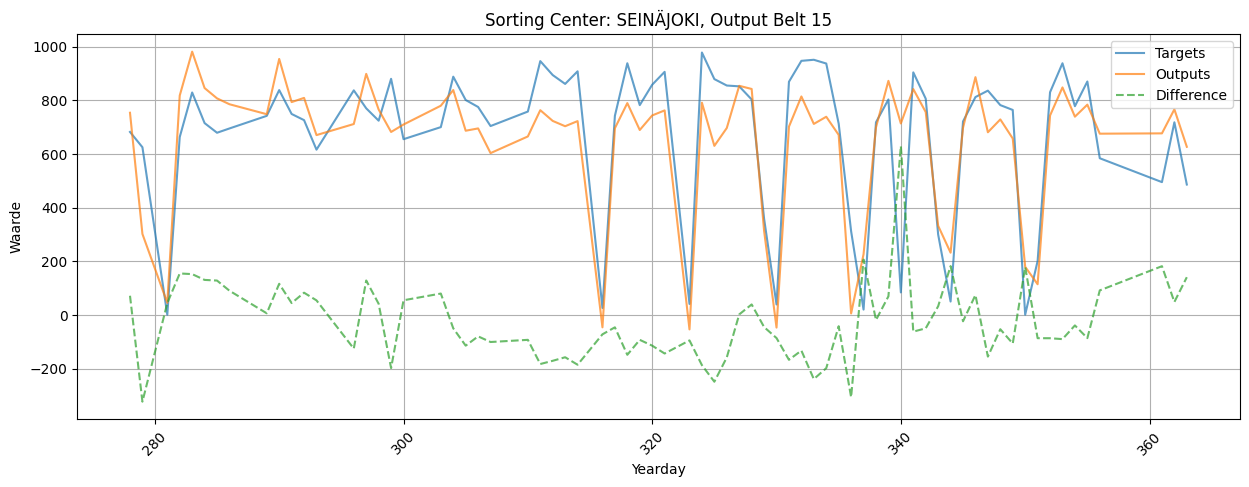

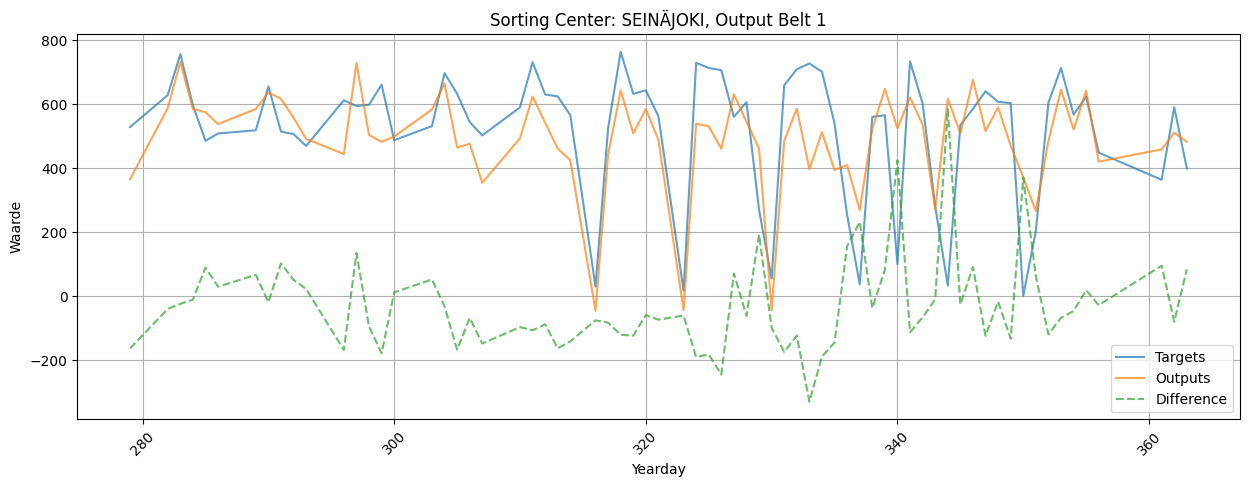

Plotting for Sorting Center: TAMPERE


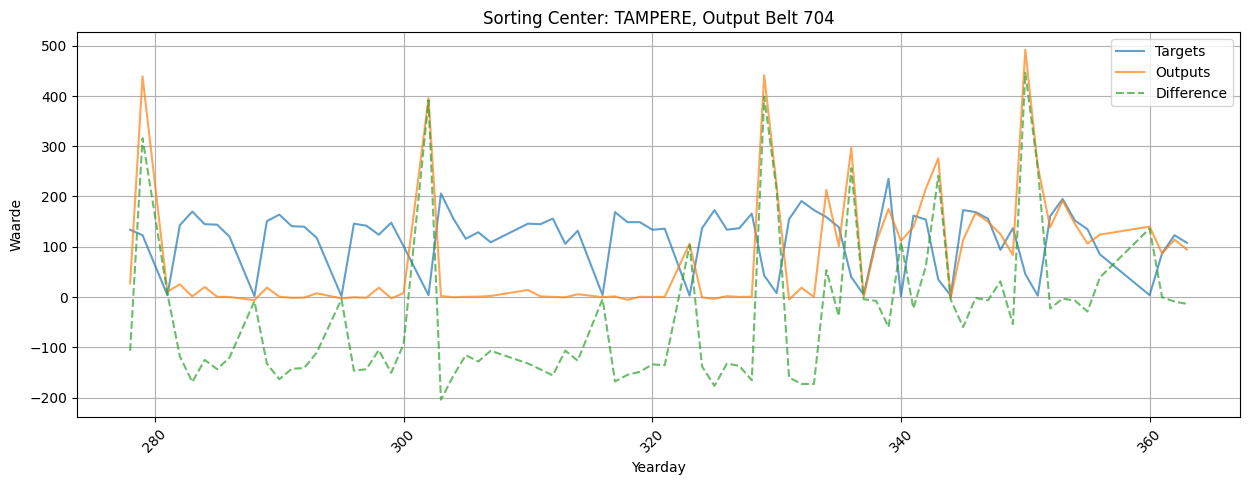

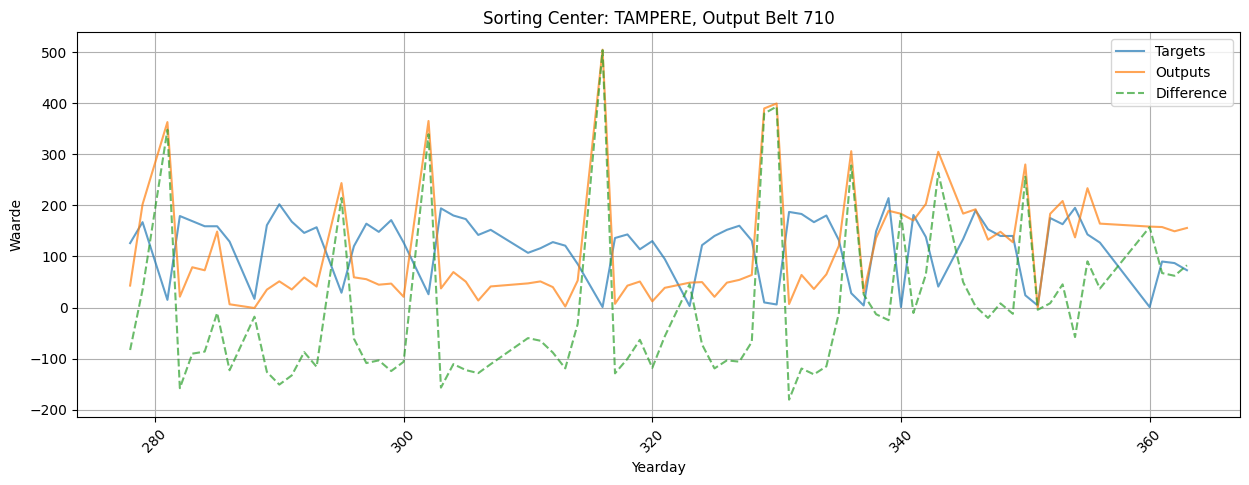

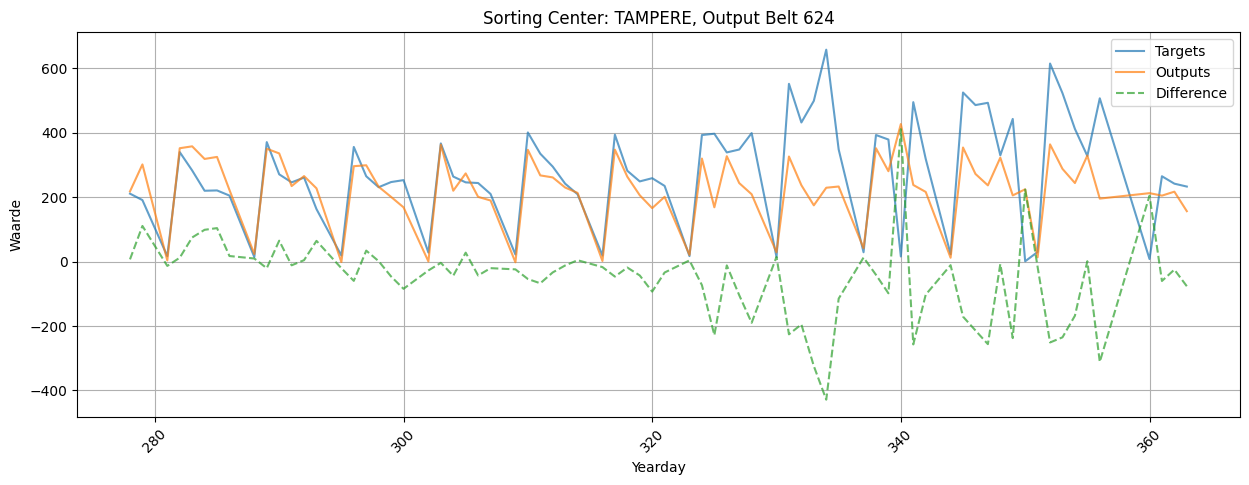

Plotting for Sorting Center: VANTAA


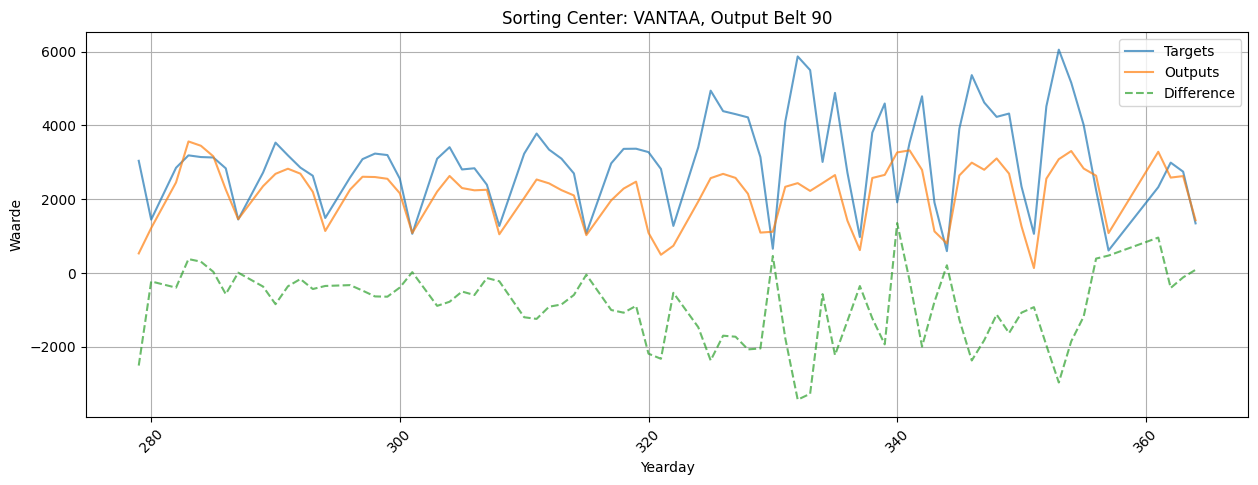

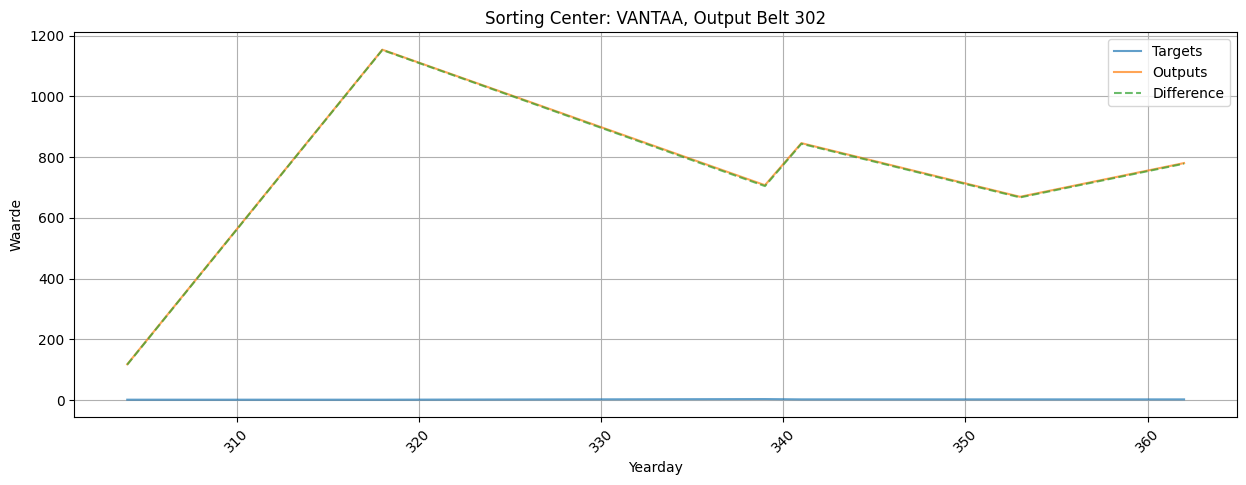

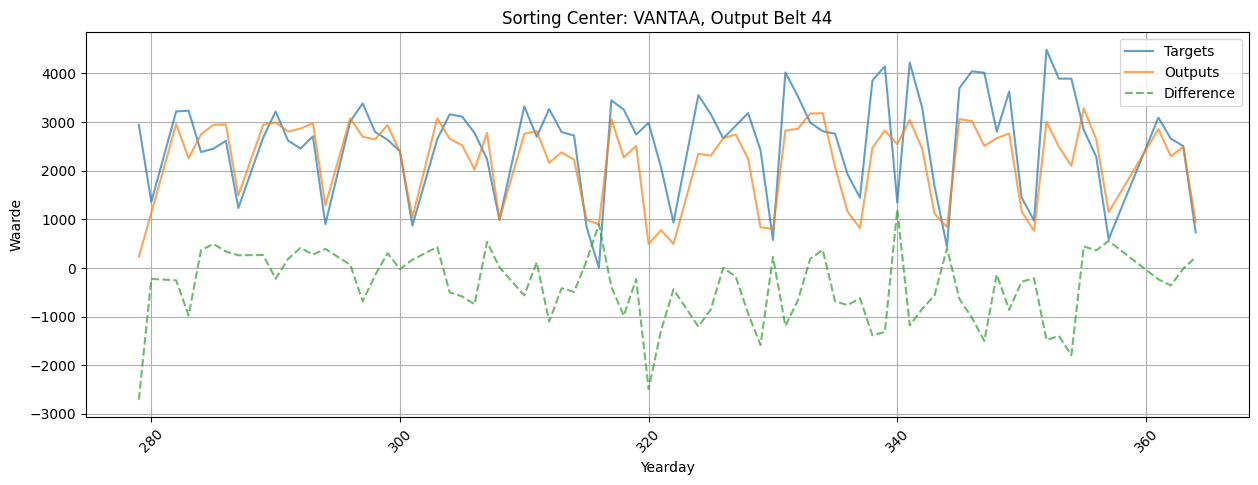

In [27]:
belts_per_center = {}

for name in loaders:
    unique_belts = np.unique([belt for _, _, belts, _ in loaders[name]['test_loader'] for belt in belts.numpy()])
    belts_per_center[name] = np.random.choice(unique_belts, size=3, replace=False)

def plot_for_all_centers(models, loaders, belts_per_center):
    for name, model in models.items():
        print(f"Plotting for Sorting Center: {name}")
        test_loader = loaders[name]['test_loader']

        belts = belts_per_center.get(name, [])
        if belts.size > 0:  # Pas deze regel aan
            plot_output_belts_for_center(model, test_loader, name, belts)

plot_for_all_centers(trained_models, loaders, belts_per_center=belts_per_center)


In [127]:
df_combined

scanning_date output_belt  no_of_events  day  month  weekday  week  \
0         2023-01-01     0_LIETO             2    1      1        7    52   
1         2023-01-01   101_LIETO            12    1      1        7    52   
2         2023-01-01   102_LIETO            15    1      1        7    52   
3         2023-01-01   103_LIETO            12    1      1        7    52   
4         2023-01-01   104_LIETO             7    1      1        7    52   
...              ...         ...           ...  ...    ...      ...   ...   
144617    2023-12-29    954_OULU           134   29     12        5    52   
144618    2023-12-29    955_OULU           236   29     12        5    52   
144619    2023-12-29    956_OULU           297   29     12        5    52   
144620    2023-12-29    957_OULU           292   29     12        5    52   
144621    2023-12-29    958_OULU           281   29     12        5    52   

        week_of_month  yearday  
0                   1        1  
1                   1        1  
2                   1        1  
3                   1        1  
4                   1        1  
...               ...      ...  
144617              5      363  
144618              5      363  
144619              5      363  
144620              5      363  
144621              5      363  

[144622 rows x 9 columns]

In [70]:
df_list = [df_LIETO, df_TAMPERE, df_SEINÄJOKI, df_KUOPIO, df_OULU]
for df, name in zip(df_list, ['LIETO', 'TAMPERE', 'SEINÄJOKI', 'KUOPIO', 'OULU']):
    df['output_belt'] = df['output_belt'].astype(str) + f'_{name}'
df_combined = pd.concat(df_list, ignore_index=True)
df_combined['output_belt_original'] = df_combined['output_belt']
df_combined['output_belt'] = pd.factorize(df_combined['output_belt'])[0]
df = df_combined

In [111]:
df['category_comb'] = (
    df['output_belt'].astype(str) + '_' + 
    df['day'].astype(str) + '_' + 
    df['weekday'].astype(str) + '_' + 
    df['week_of_month'].astype(str)
)

# Encodeer de gecombineerde categorieën
df['category_encoded'] = df['category_comb'].astype('category').cat.codes
df

sorting_center_name event_type scanning_date  output_belt  \
16791                VANTAA        LAJ    2023-01-02            1   
16792                VANTAA        LAJ    2023-01-02           10   
16793                VANTAA        LAJ    2023-01-02           10   
16794                VANTAA        LAJ    2023-01-02           10   
16795                VANTAA        LAJ    2023-01-02           10   
...                     ...        ...           ...          ...   
8789785                OULU        LAJ    2023-12-27            0   
8789786                OULU        LAJ    2023-12-27            0   
8789787                OULU        LAJ    2023-12-28            0   
8789788                OULU        LAJ    2023-12-28            0   
8789789                OULU        LAJ    2023-12-29            0   

         no_of_events  day  month  weekday  week  week_of_month  yearday  \
16791              13    2      1        1     1              1        2   
16792               4    2      1        1     1              1        2   
16793               2    2      1        1     1              1        2   
16794               7    2      1        1     1              1        2   
16795               3    2      1        1     1              1        2   
...               ...  ...    ...      ...   ...            ...      ...   
8789785           105   27     12        3    52              4      361   
8789786           707   27     12        3    52              4      361   
8789787             3   28     12        4    52              4      362   
8789788           792   28     12        4    52              4      362   
8789789           669   29     12        5    52              5      363   

        category_comb  category_encoded  
16791         1_2_1_1              8640  
16792        10_2_1_1              2251  
16793        10_2_1_1              2251  
16794        10_2_1_1              2251  
16795        10_2_1_1              2251  
...               ...               ...  
8789785      0_27_3_4               127  
8789786      0_27_3_4               127  
8789787      0_28_4_4               135  
8789788      0_28_4_4               135  
8789789      0_29_5_5               143  

[7450939 rows x 13 columns]

In [73]:
train_df, test_df = split_dataset(df)

train_loader = DataLoader(EventDataset(train_df), batch_size=512, shuffle=False)
test_loader = DataLoader(EventDataset(test_df), batch_size=512, shuffle=True)


In [77]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=5, min_delta=0.01):
    train_losses, test_losses = [], []
    early_stopping_counter = 0  # Teller om het aantal niet-verbeterende epochs bij te houden

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for inputs, targets, _ in train_loader:
        for inputs, targets, _, _ in train_loader:  # Voeg een extra underscore toe om yearday te negeren

            inputs = inputs.to(device)
            targets = targets.float().to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs).squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        avg_train_loss = running_loss / len(train_loader)
        # avg_train_loss = (running_loss / len(train_loader)) ** 0.5  # Vierkantswortel voor RMSE
        train_losses.append(avg_train_loss)
        
        # Evaluatie
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            # for inputs, targets, _ in test_loader:
            for inputs, targets, _, _ in test_loader:  # Voeg een extra underscore toe om yearday te negeren
                inputs = inputs.to(device)
                targets = targets.float().to(device)
                outputs = model(inputs).squeeze()
                total_loss += criterion(model(inputs).squeeze(), targets).item()

        print(f"Targets: {targets[:5].cpu().numpy()}, Outputs: {outputs[:5].cpu().detach().numpy()}")
        avg_test_loss = (total_loss / len(test_loader))
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early Stopping logica
        if epoch >= patience:
            if avg_test_loss > test_losses[-patience]:  # Vergelijk met de test loss van `patience` epochs geleden
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0  # Reset de teller als er verbetering is
        
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break


    return train_losses, test_losses



Targets: [156. 283.   0.  88. 439.], Outputs: [58.54819 84.47447 69.32046 61.60483 58.03865]
Epoch [1/200], Train Loss: 202.7665, Test Loss: 141.4159, LR: 0.080000
Targets: [  0.  26. 351. 367. 280.], Outputs: [ 59.837902 124.34915   78.36072  128.69545   89.31066 ]
Epoch [2/200], Train Loss: 153.0447, Test Loss: 141.6177, LR: 0.080000
Targets: [  0. 190. 115. 315.   3.], Outputs: [ 92.96262   99.069214  57.251938 181.68614   48.382393]
Epoch [3/200], Train Loss: 128.1610, Test Loss: 142.1418, LR: 0.080000
Targets: [446. 132.  30. 107. 156.], Outputs: [ 70.263115  95.075096 172.21953   67.26902  201.84062 ]
Epoch [4/200], Train Loss: 116.3361, Test Loss: 139.9925, LR: 0.080000
Targets: [ 45.  94.  20. 288. 215.], Outputs: [124.134285 229.64653   91.903336 153.70987   89.50143 ]
Epoch [5/200], Train Loss: 108.9953, Test Loss: 142.1684, LR: 0.080000
Targets: [259.   5.  34.  77.   4.], Outputs: [136.30226   23.554157  30.201355  49.253517 172.04727 ]
Epoch [6/200], Train Loss: 104.9271, 

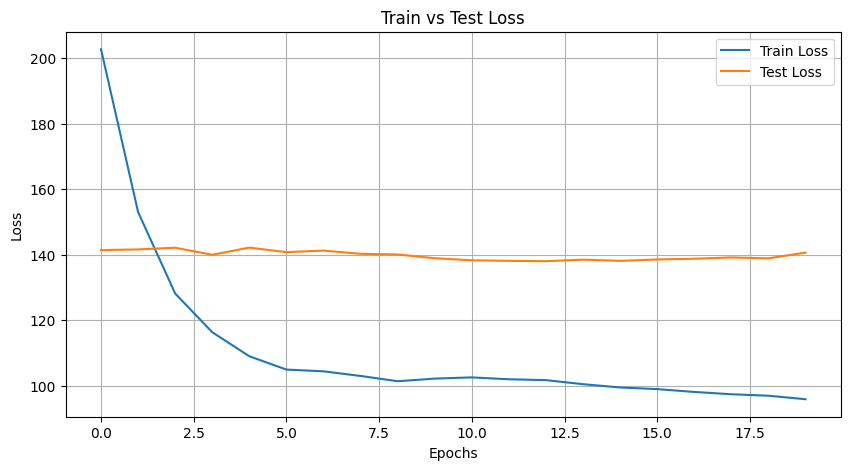

In [78]:
num_categories = len(df['category_encoded'].unique())
embedding_dim = 4

model = SimpleNN(num_categories=num_categories, embedding_dim=embedding_dim).to(device)
criterion = nn.L1Loss()
# criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.08)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=200)
plot_losses(train_losses, test_losses)

In [80]:
all_outputs, all_targets, all_output_belts, all_yeardays = [], [], [], []

for inputs, targets, output_belts, yearday in test_loader:
    inputs, targets = inputs.to(device), targets.float().to(device)
    all_outputs.append(model(inputs).squeeze().cpu().detach().numpy())
    all_targets.append(targets.cpu().numpy())
    all_output_belts.append(output_belts.cpu().numpy())
    all_yeardays.append(yearday.cpu().numpy())

all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, (all_outputs, all_targets, all_output_belts, all_yeardays))

for belt in [1, 2,3 ]:
    mask = all_output_belts == belt
    if mask.any():
        sort_idx = np.argsort(all_yeardays[mask])
        plt.figure(figsize=(15, 5))
        plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], label='Difference', linestyle='--', alpha=0.7)
        plt.xlabel('Yearday')
        plt.ylabel('Waarde')
        plt.title(f'Output Belt {belt}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

In [82]:
print(np.unique(all_output_belts))
print(f"Belt {belt}: {mask.sum()} rows")
print(len(all_outputs), len(all_targets), len(all_output_belts), len(all_yeardays))
random_belts = np.random.choice(np.unique(all_output_belts), 10, replace=False)


[297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515]
Belt 3: 0 rows
46792 46792 46792 46792


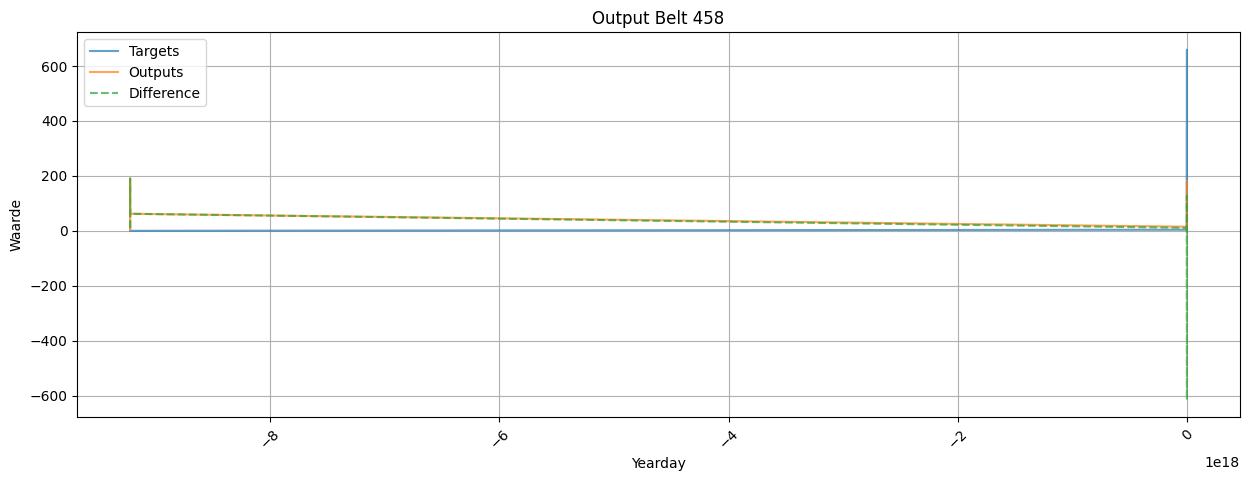

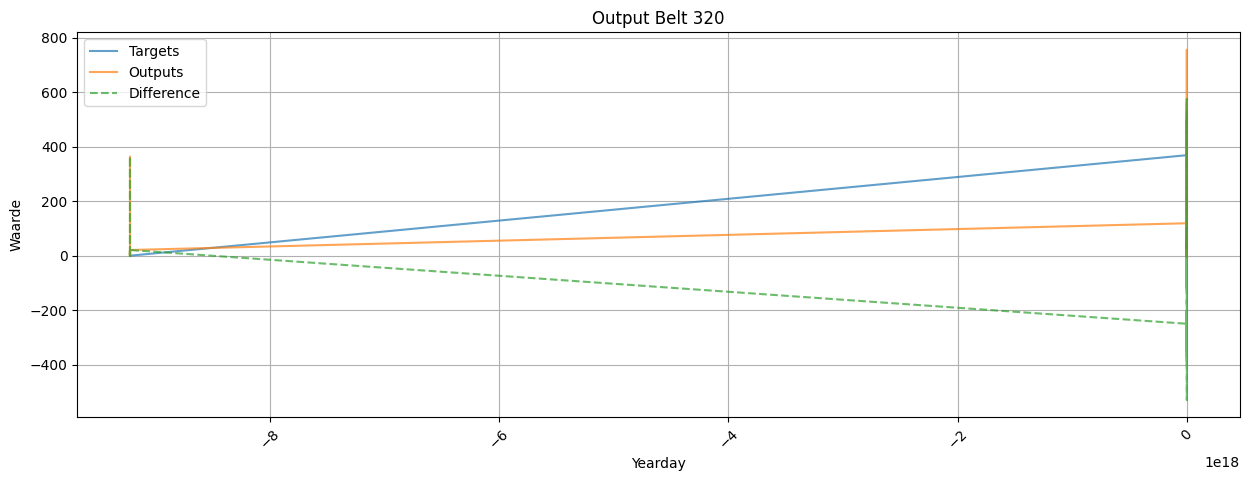

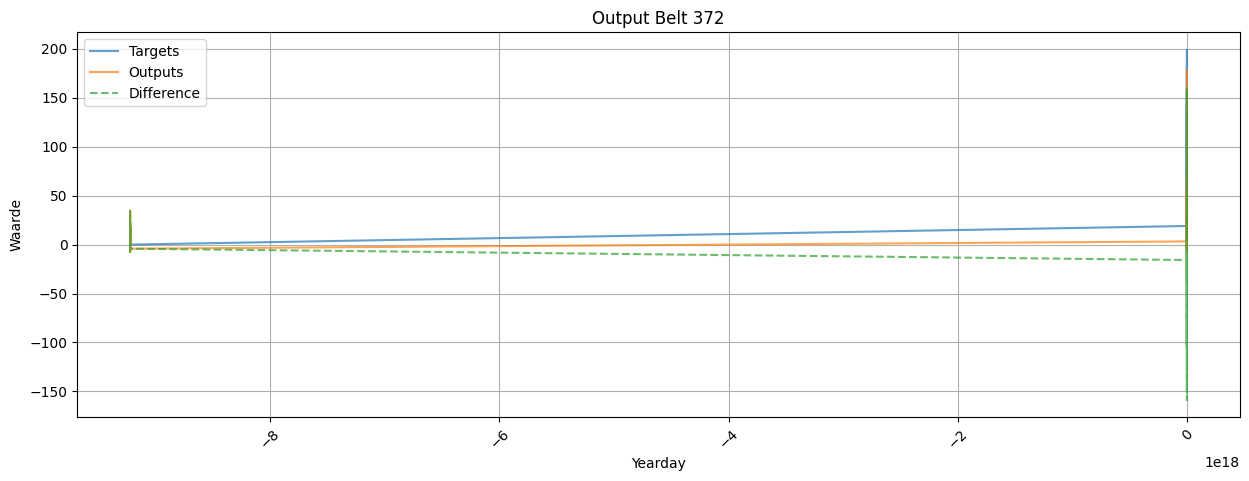

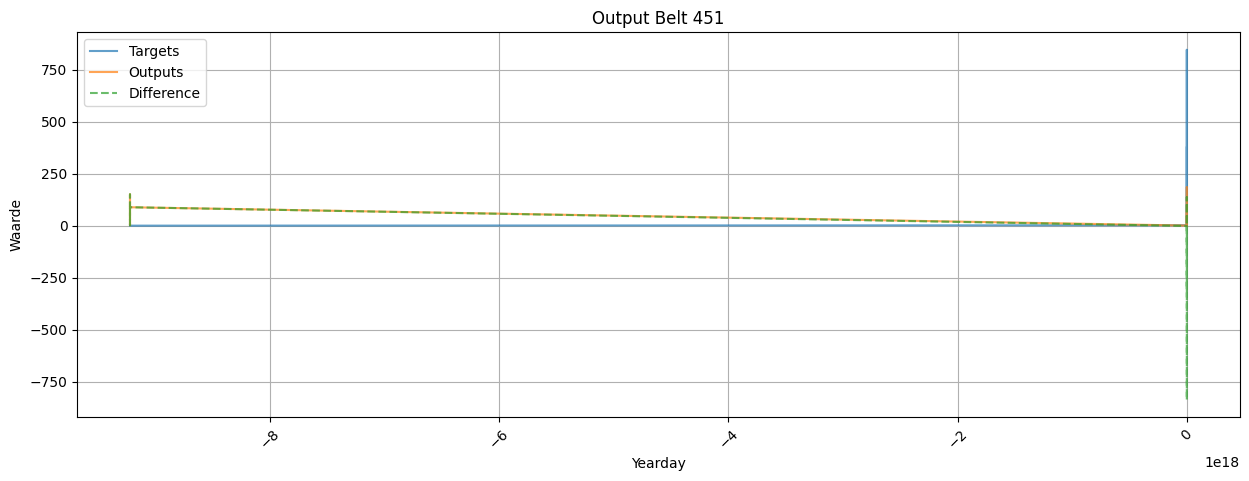

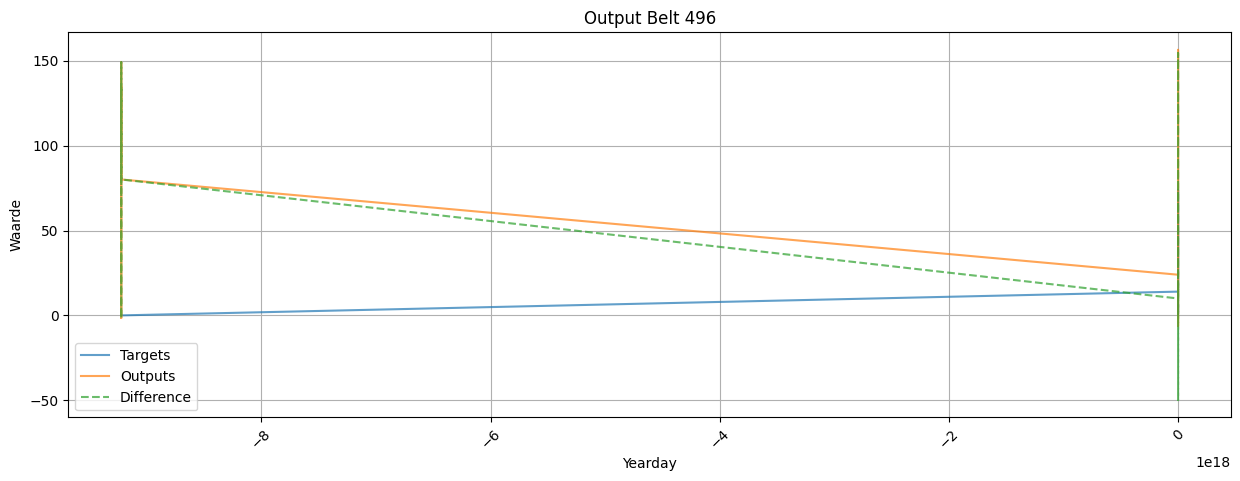

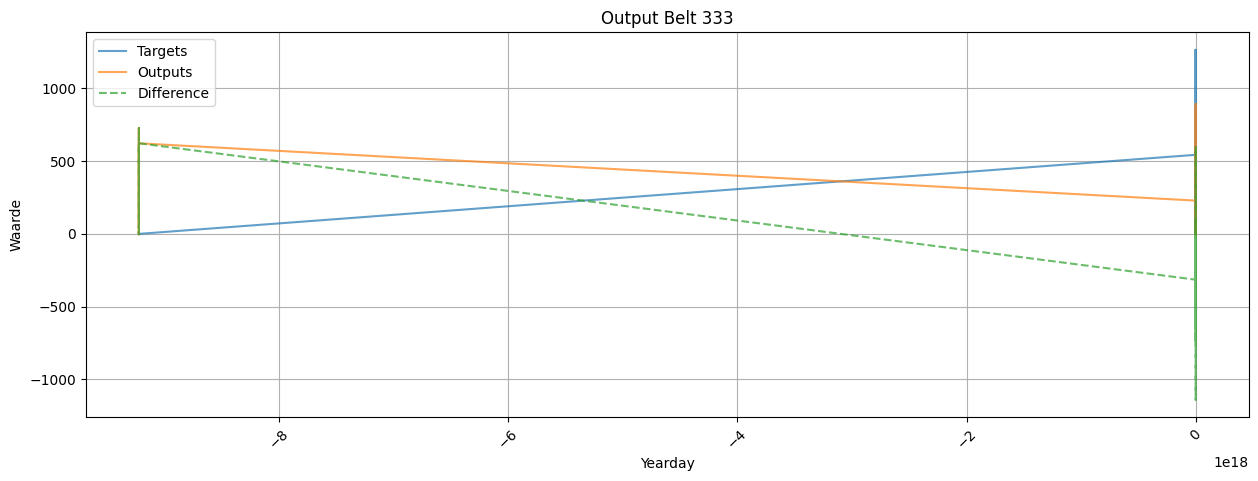

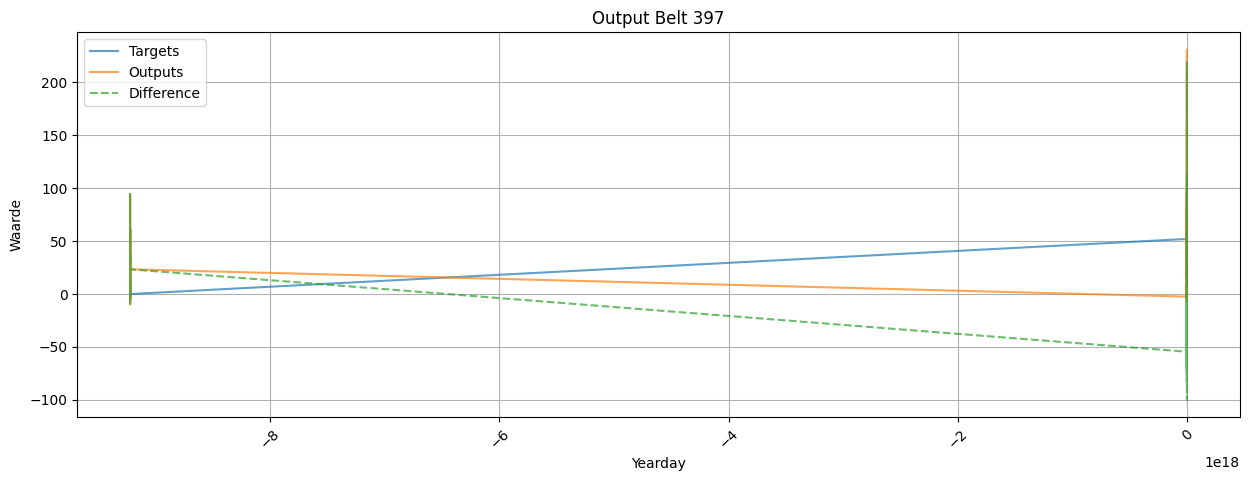

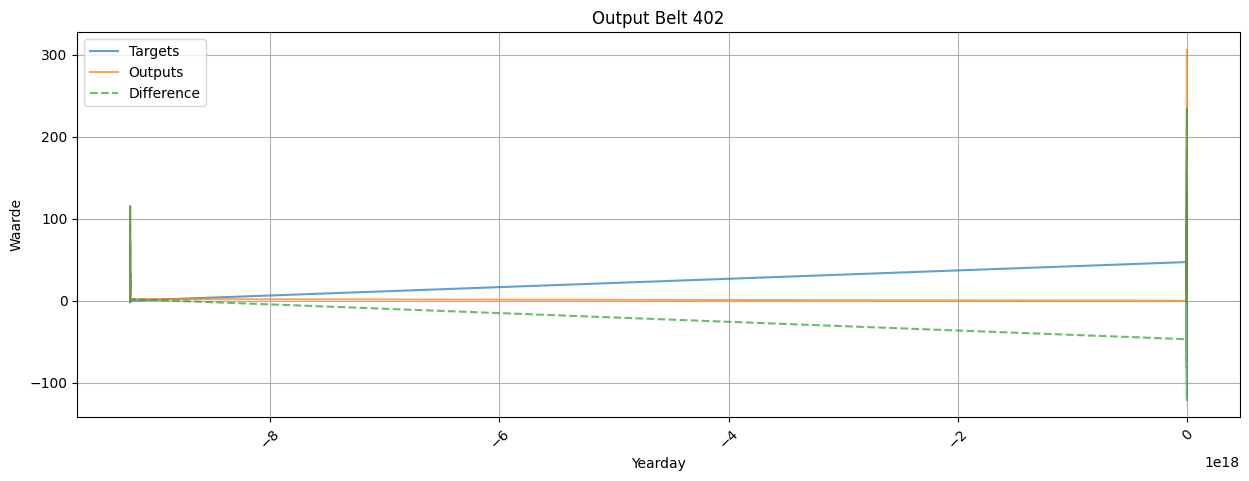

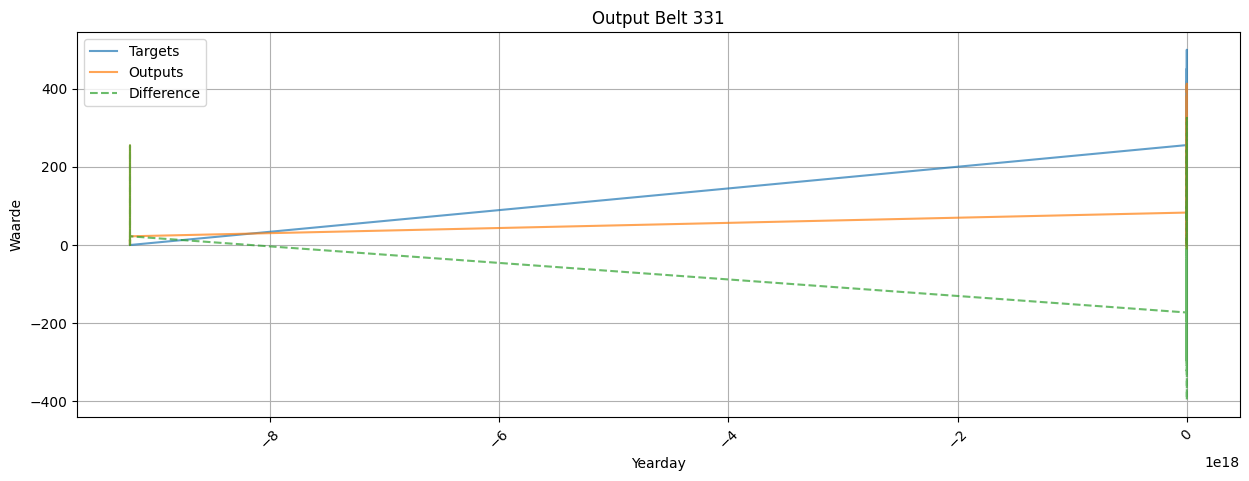

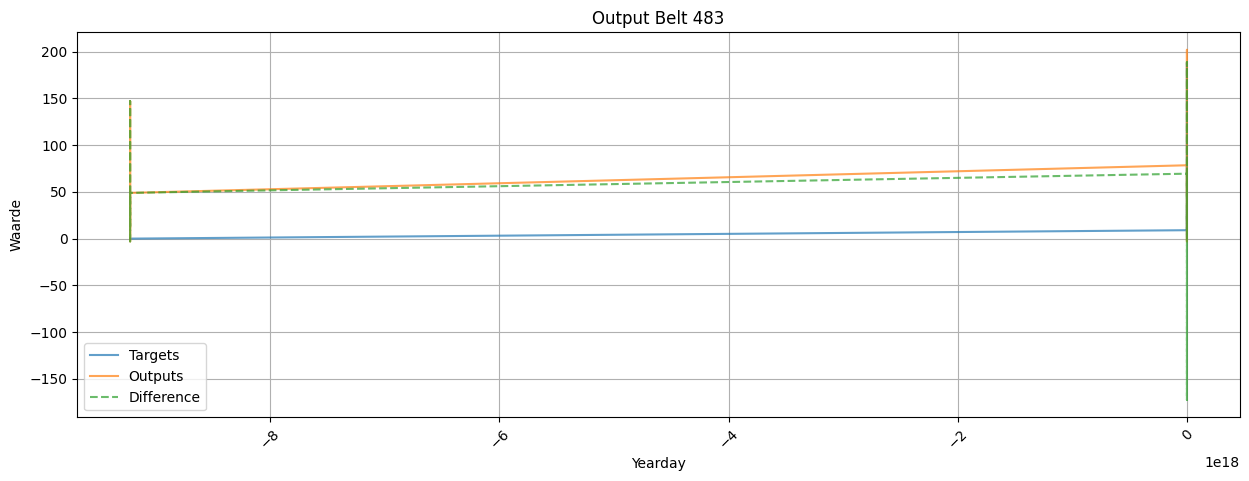

In [83]:
# Selecteer willekeurige output_belts uit de beschikbare output_belts
random_belts = np.random.choice(np.unique(all_output_belts), 10, replace=False)

for belt in random_belts:
    mask = all_output_belts == belt
    if mask.any():
        sort_idx = np.argsort(all_yeardays[mask])
        plt.figure(figsize=(15, 5))
        plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
        plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], label='Difference', linestyle='--', alpha=0.7)
        plt.xlabel('Yearday')
        plt.ylabel('Waarde')
        plt.title(f'Output Belt {belt}')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()


In [55]:
df

scanning_date  output_belt  no_of_events  day  month  weekday  week  \
0         2023-01-01            0           2.0    1      1        7    52   
1         2023-01-01            1          12.0    1      1        7    52   
2         2023-01-01            2          15.0    1      1        7    52   
3         2023-01-01            3          12.0    1      1        7    52   
4         2023-01-01            4           7.0    1      1        7    52   
...              ...          ...           ...  ...    ...      ...   ...   
187161    2023-12-29          511          15.0   29     12        5    52   
187162    2023-12-29          512          30.0   29     12        5    52   
187163    2023-12-29          513         481.0   29     12        5    52   
187164    2023-12-29          514         244.0   29     12        5    52   
187165    2023-12-29          515         281.0   29     12        5    52   

        week_of_month  yearday output_belt_original category_comb  \
0                   1      1.0        0_LIETO_LIETO       0_1_7_1   
1                   1      1.0      101_LIETO_LIETO       1_1_7_1   
2                   1      1.0      102_LIETO_LIETO       2_1_7_1   
3                   1      1.0      103_LIETO_LIETO       3_1_7_1   
4                   1      1.0      104_LIETO_LIETO       4_1_7_1   
...               ...      ...                  ...           ...   
187161              5    363.0        655_OULU_OULU    511_29_5_5   
187162              5    363.0        708_OULU_OULU    512_29_5_5   
187163              5    363.0        758_OULU_OULU    513_29_5_5   
187164              5    363.0        855_OULU_OULU    514_29_5_5   
187165              5    363.0        958_OULU_OULU    515_29_5_5   

        category_encoded  
0                     76  
1                  23941  
2                  47806  
3                  71671  
4                  95536  
...                  ...  
187161             98399  
187162             98614  
187163             98829  
187164             99044  
187165             99259  

[187166 rows x 12 columns]